In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import json
import os
from pathlib import Path
import numpy as np
import seaborn as sns
import result_handler as rh
from sklearn.metrics import confusion_matrix, f1_score, precision_score, accuracy_score, recall_score



In [2]:
RELOAD_DATA = True
RESULTS_DIR = Path('../translations')
RESULTS_NAME = 'cross_tests_results_final.csv'

if RELOAD_DATA:
    rh.concatenate_csv_files(RESULTS_DIR, 'predictions.csv', RESULTS_NAME)

df = pd.read_csv(RESULTS_NAME)

models_map = {'xlm-roberta-base': 'XLM-RoBERTa (Base)',
              'neuralmind/bert-large-portuguese-cased': 'BERTimbau (Large)'}

datasets_map = {'dlb/plue': 'PLUE-MNLI',
              'assin': 'ASSIN',
              'assin2': 'ASSIN2'}

df['test_dataset'] = df['test_dataset'].map(datasets_map)
df['train_dataset'] = df['train_dataset'].map(datasets_map)
df['model_name'] = df['model_name'].map(models_map)

In [3]:
grouped = df.groupby(['model_name', 'train_dataset', 'test_dataset'])
normalize = 'true' #Normalize the confusion matrix by row (true) or by column (pred)
def plot_consufion_matrices(grouped: pd.DataFrame, normalize: str = 'true'):
    if normalize == 'true':
        norm = 'by the true labels'
    else:
        norm = 'by the predicted labels'

    for (model, train_ds, test_ds), group in grouped:
        # Compute confusion matrix
        labels = sorted(set(group['label'].unique().tolist() + group['prediction'].unique().tolist()))
        cm = confusion_matrix(group['label'], group['prediction'], labels=labels, normalize=normalize)
        
        # Plot the confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt=".2f", vmin = 0, vmax = 1, cmap='Blues', xticklabels=labels, yticklabels=labels)
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.title(f'Model: {model}\nTrain Dataset: {train_ds}\nTest Dataset: {test_ds}\n Normalized by {norm}', loc = 'left')
        plt.show()


In [4]:
df[df['model_name'] == 'xlm-roberta-base'].groupby(['train_dataset', 'test_dataset']).count()

,,model_name,index,prediction,label
train_dataset,test_dataset,,,,


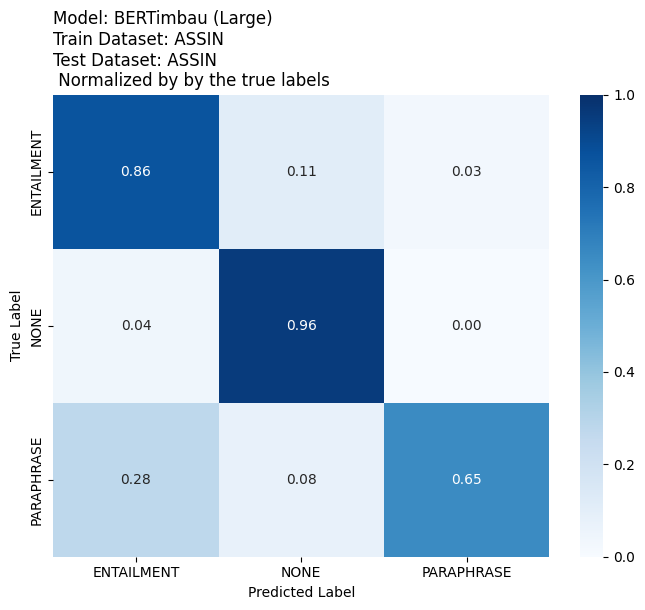

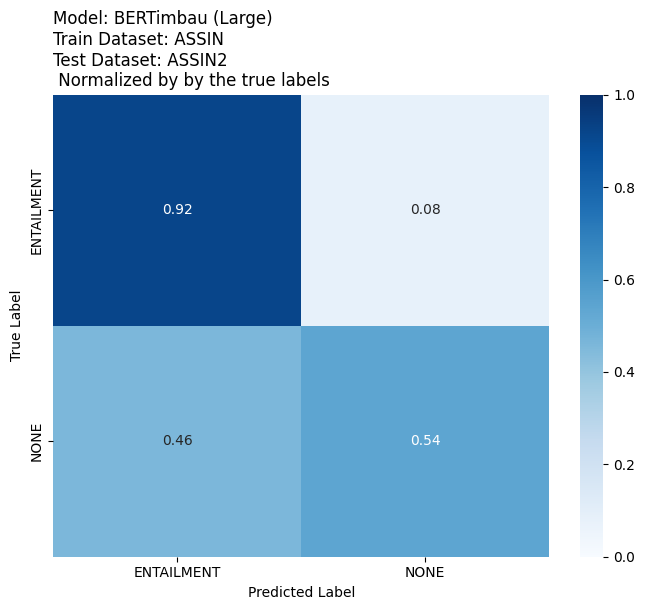

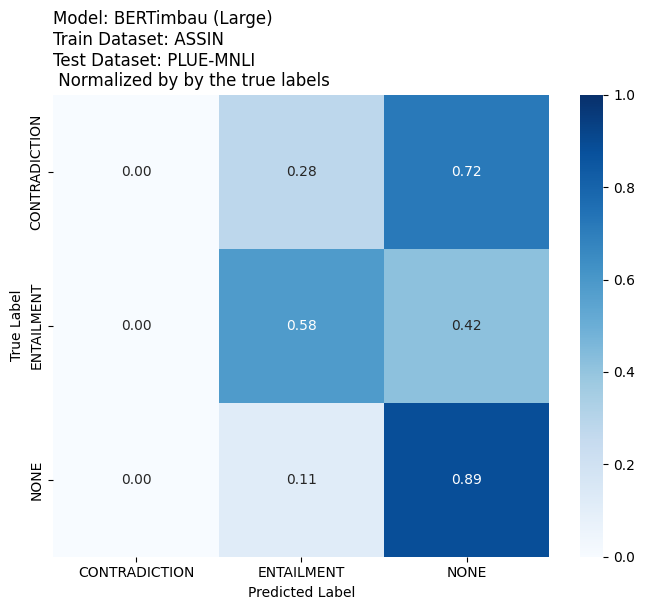

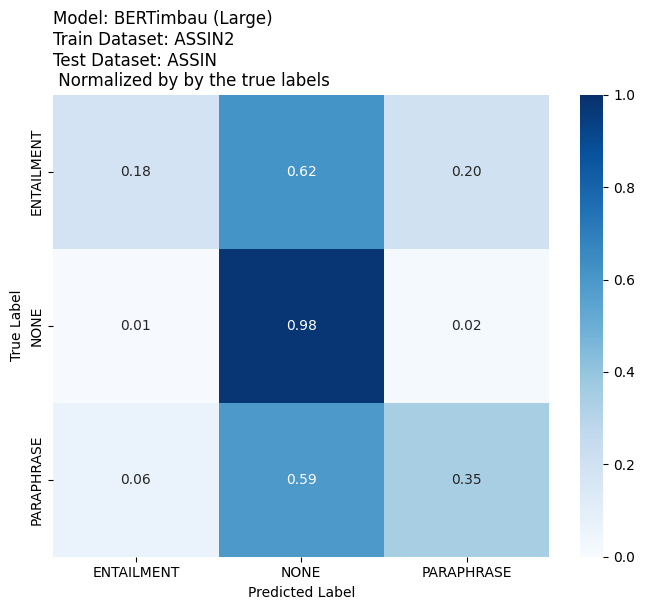

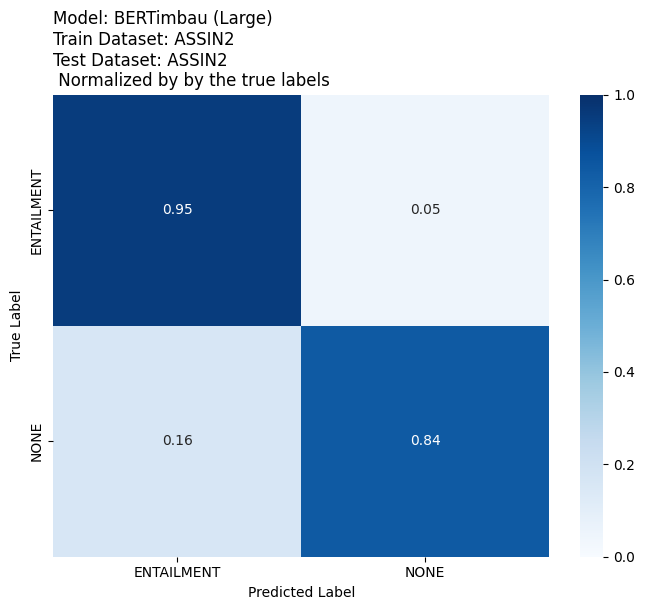

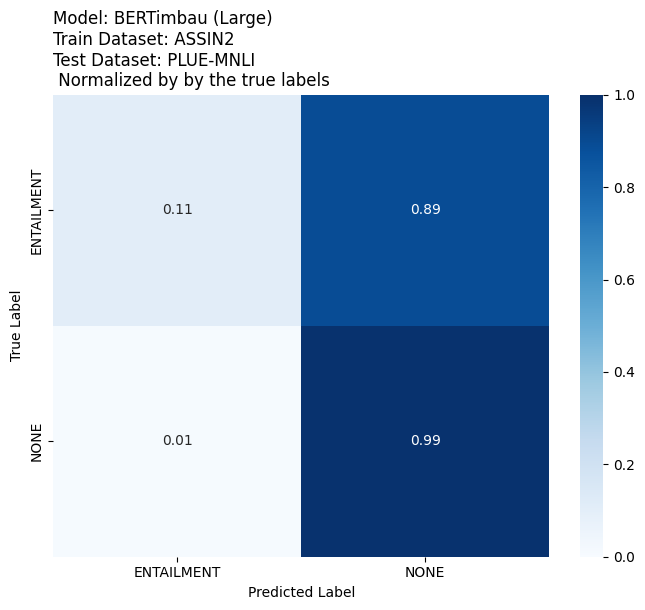

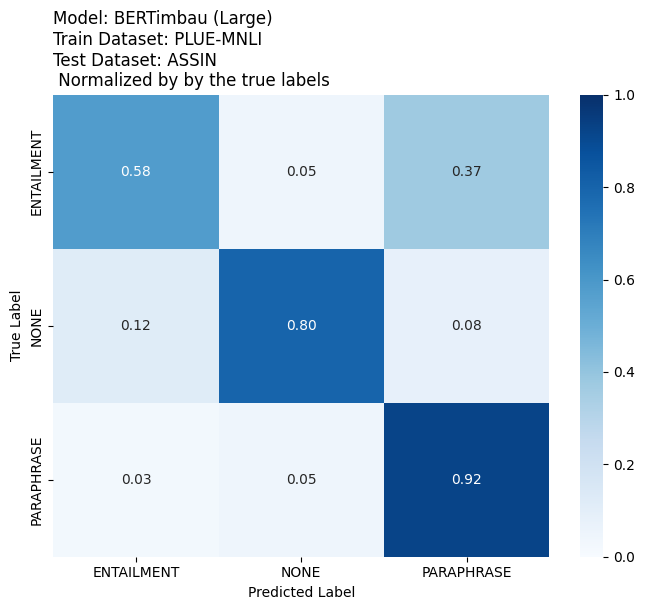

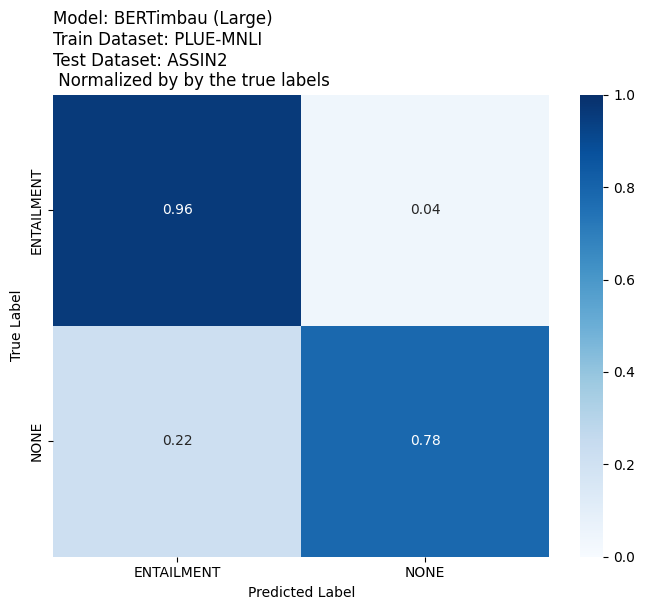

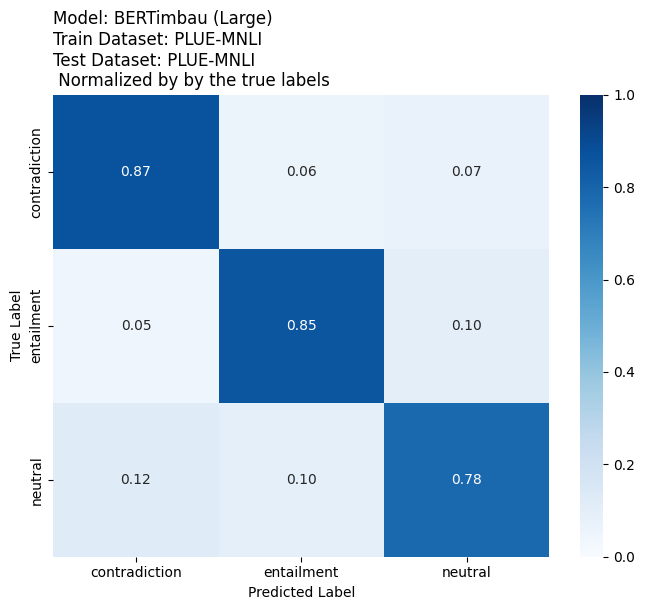

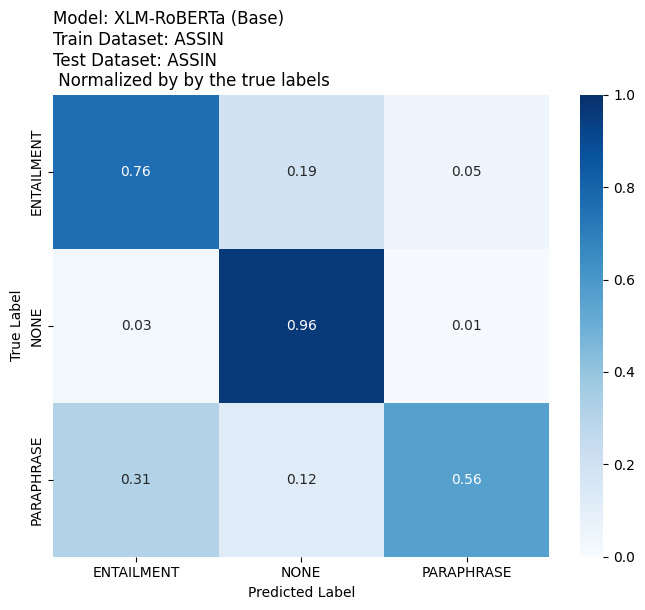

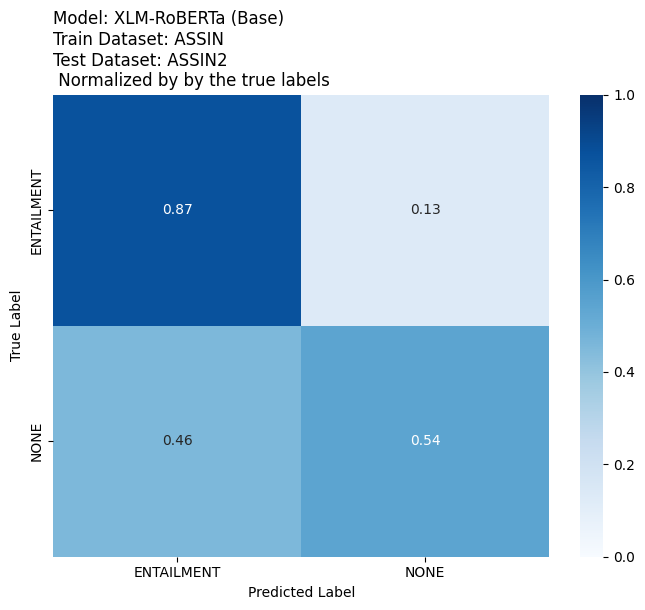

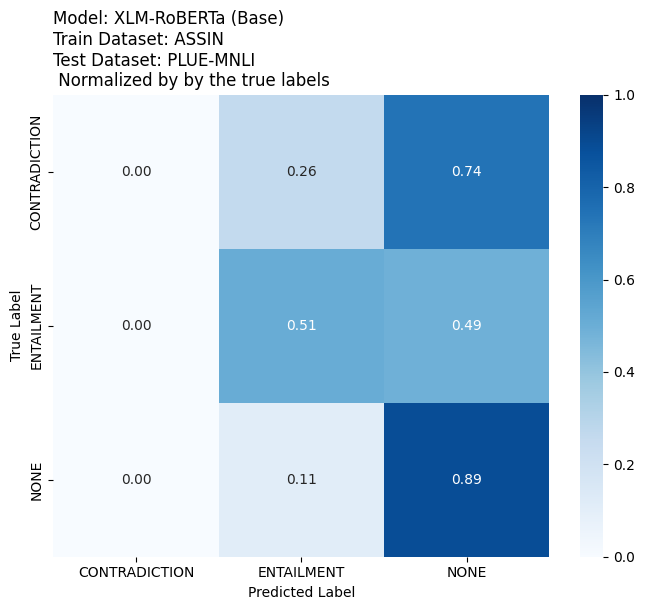

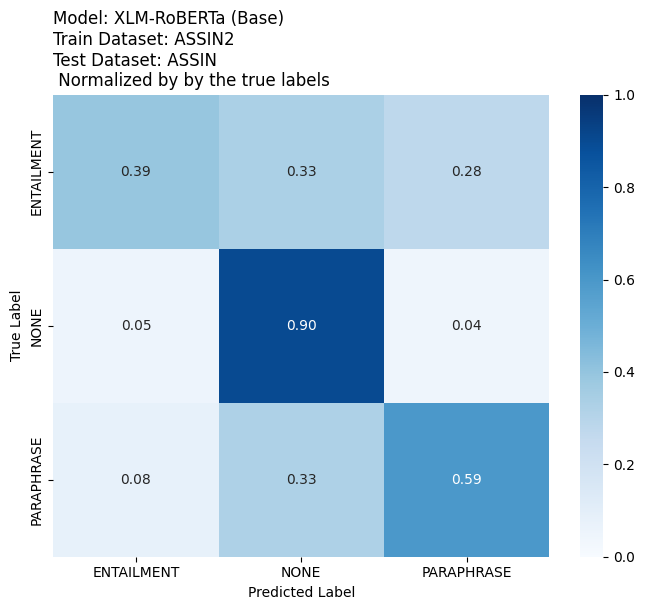

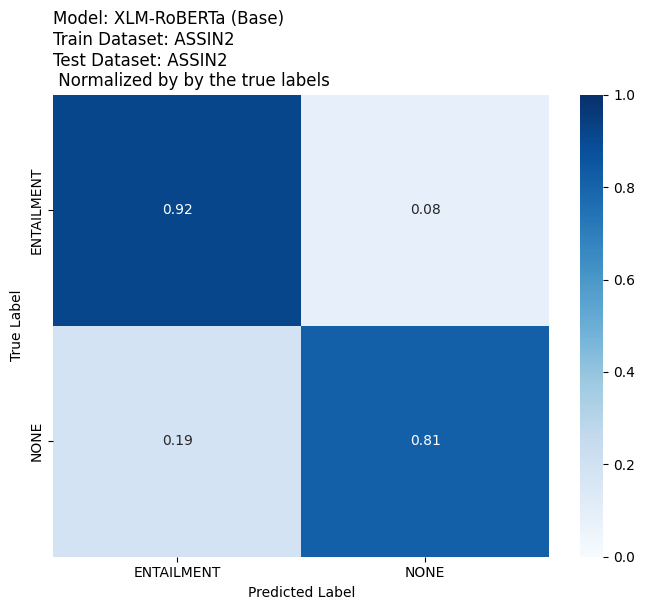

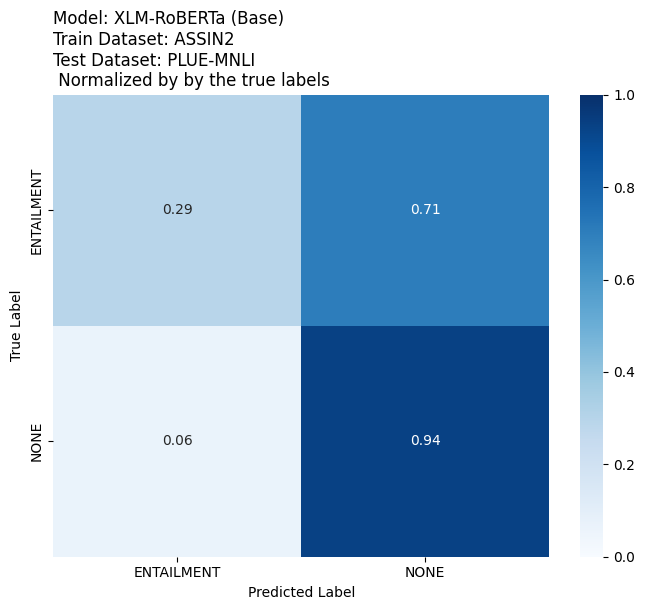

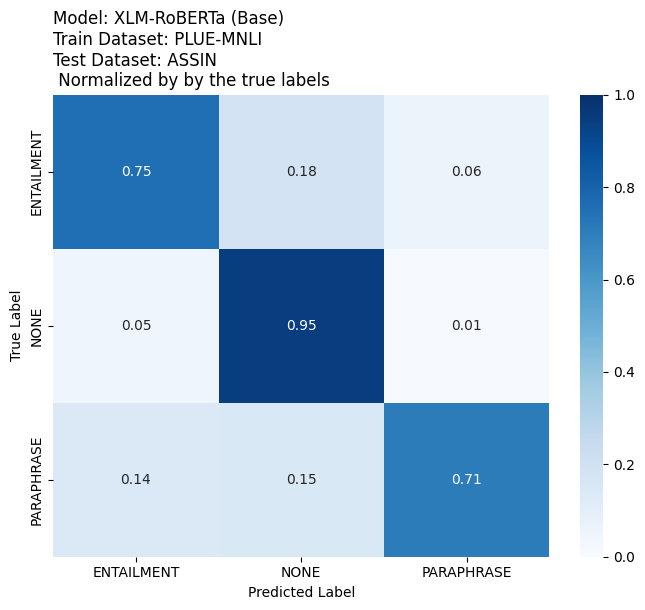

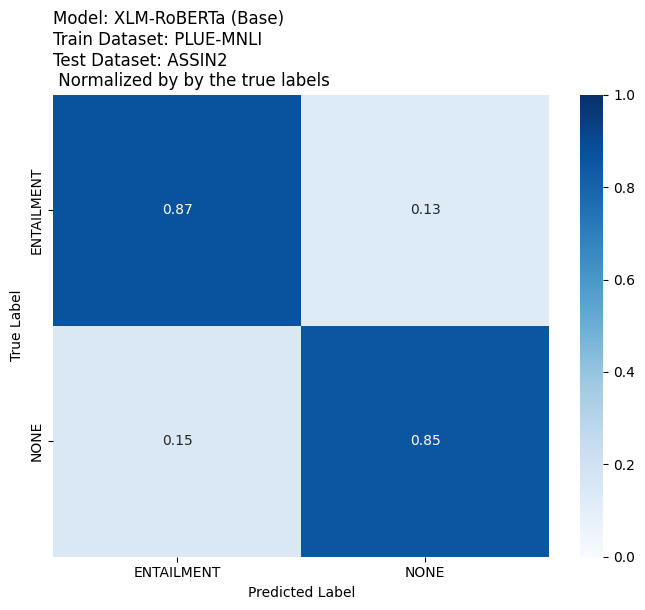

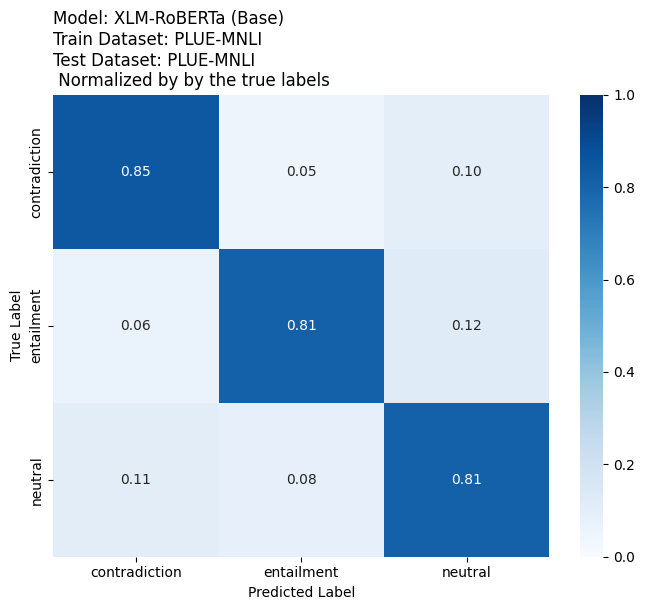

In [5]:
plot_consufion_matrices(grouped, normalize='true')  

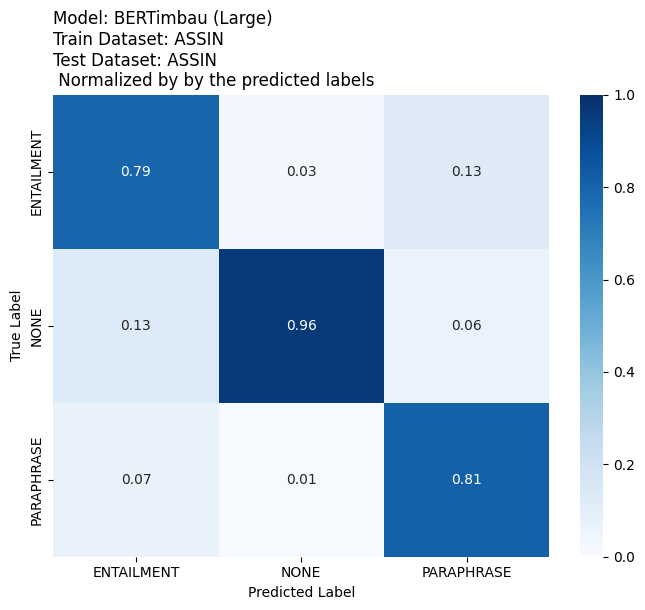

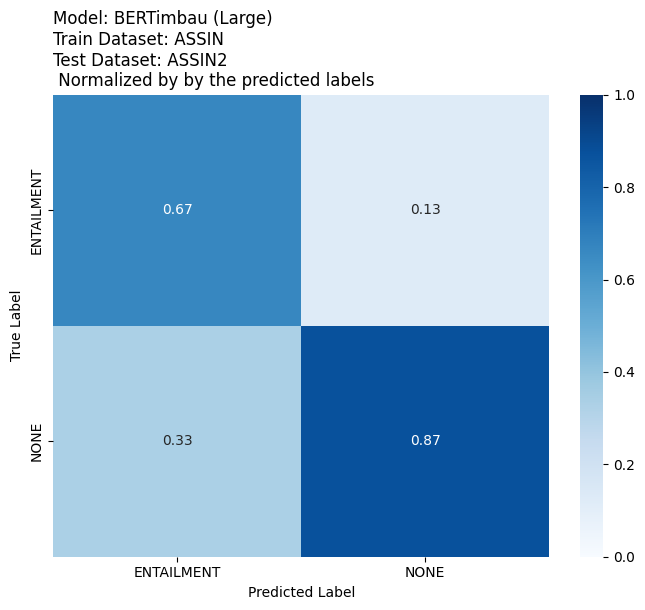

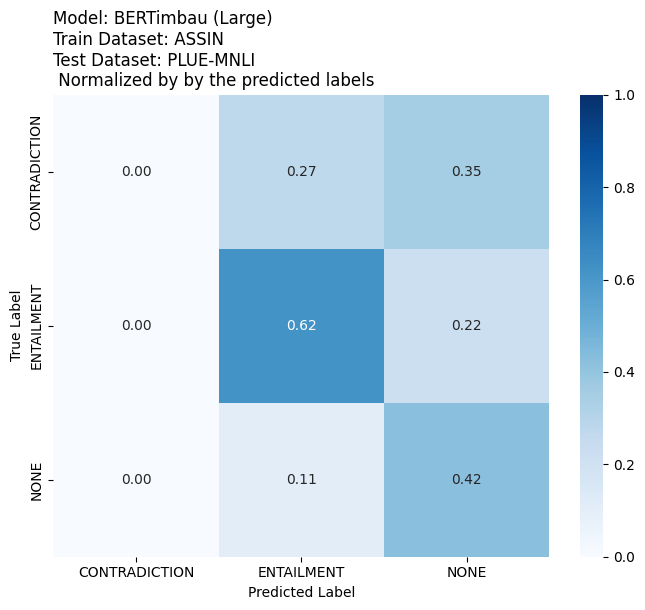

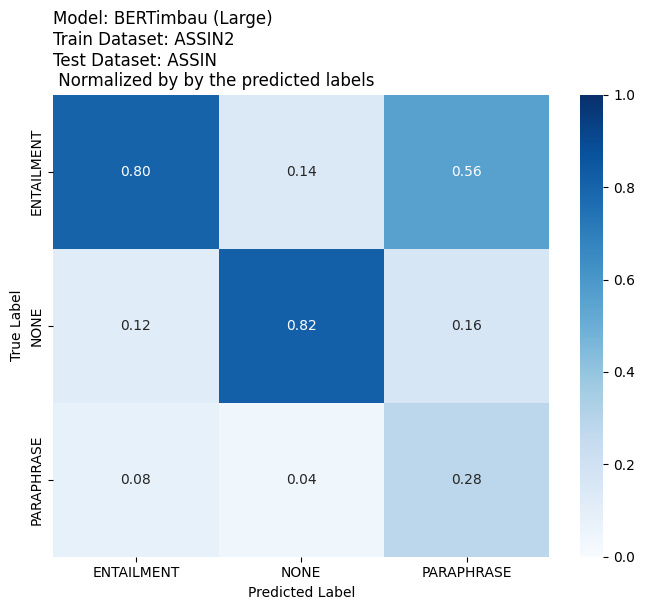

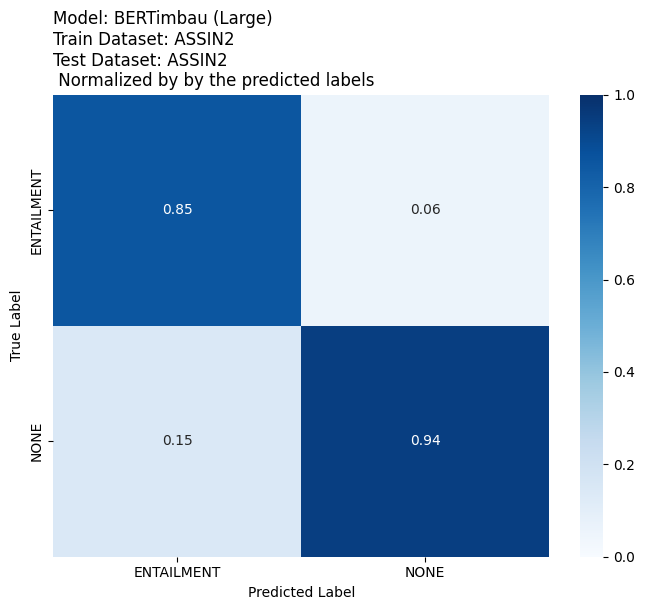

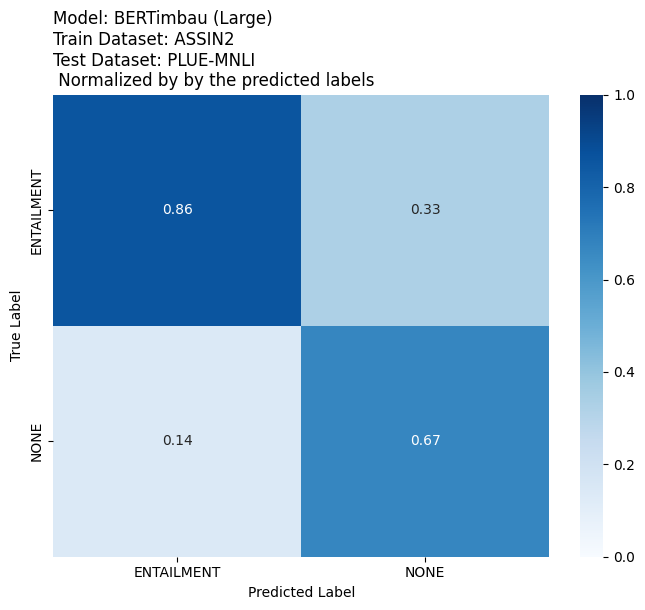

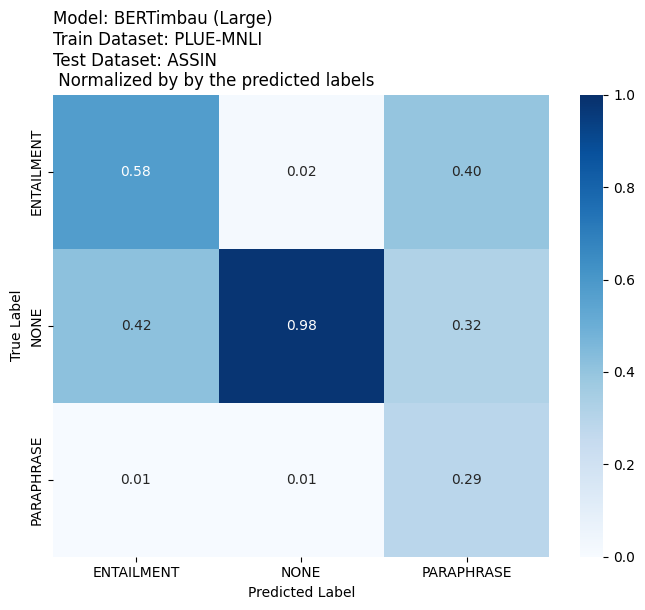

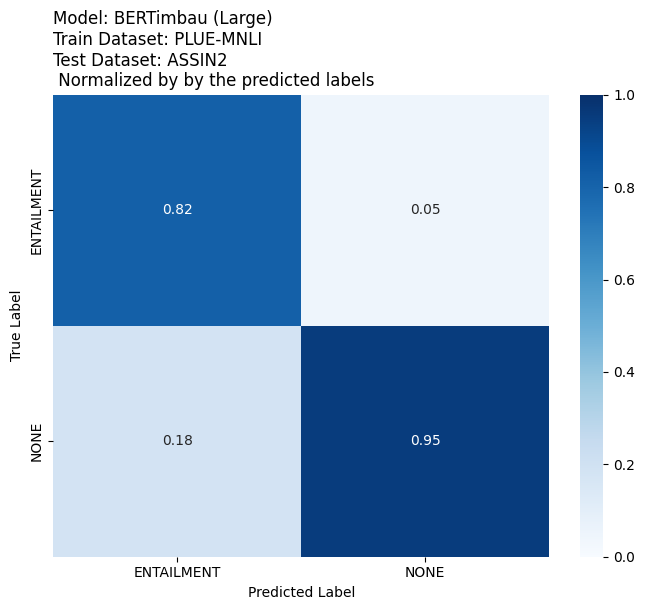

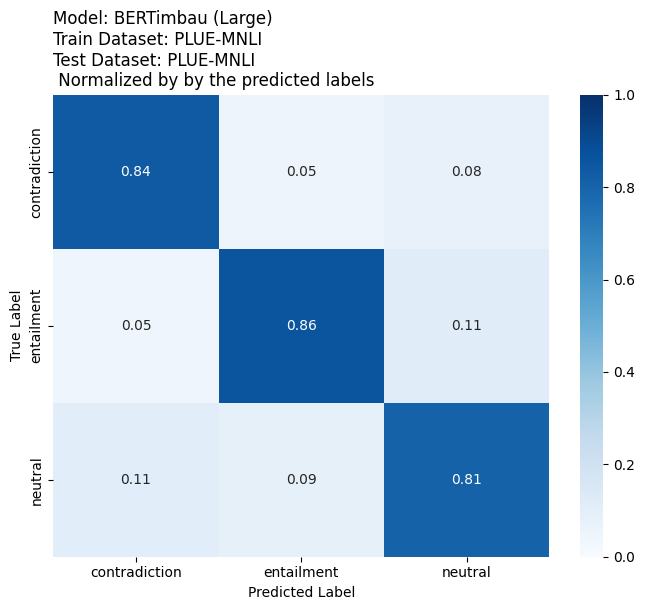

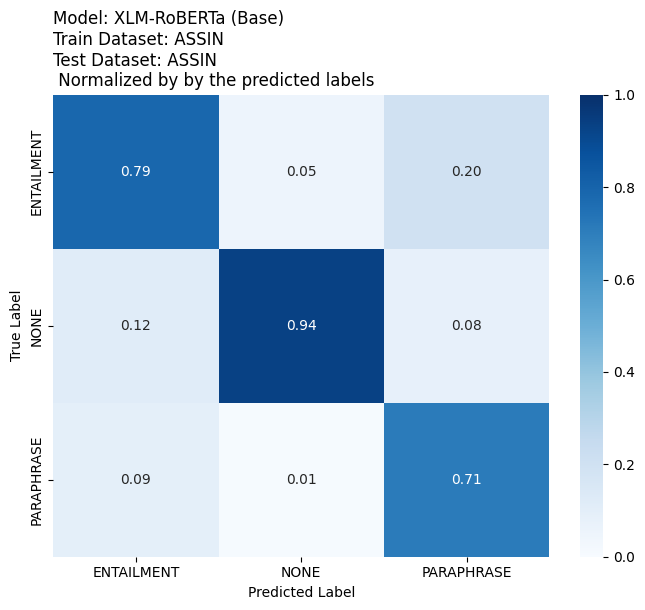

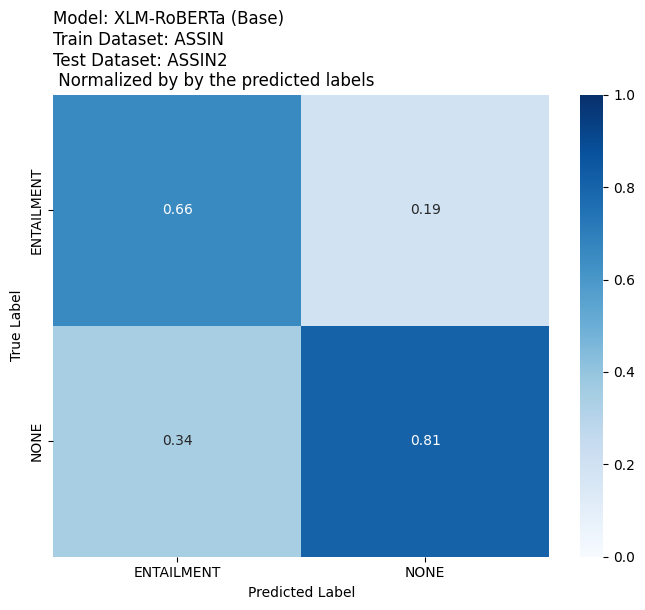

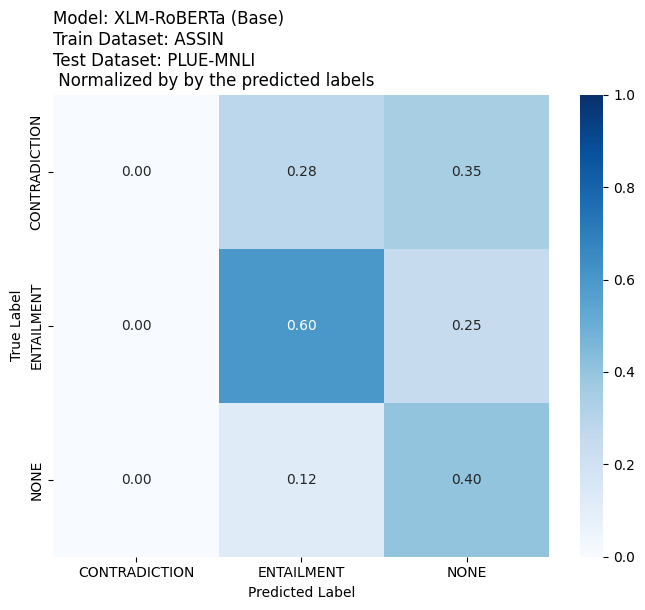

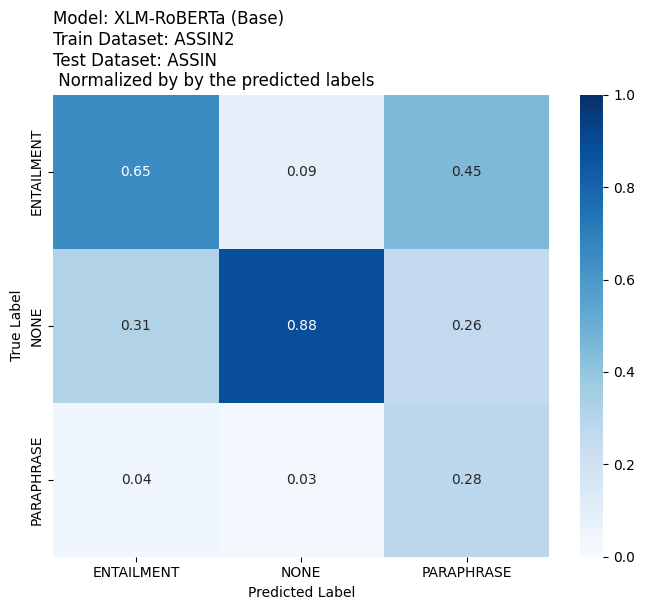

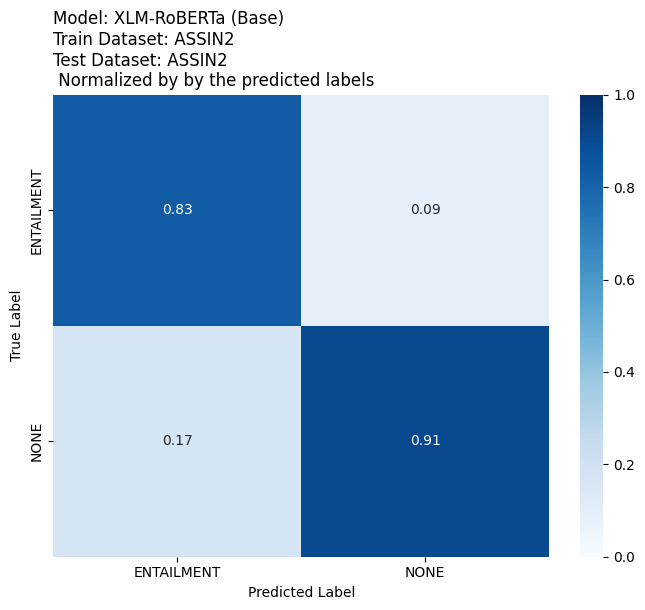

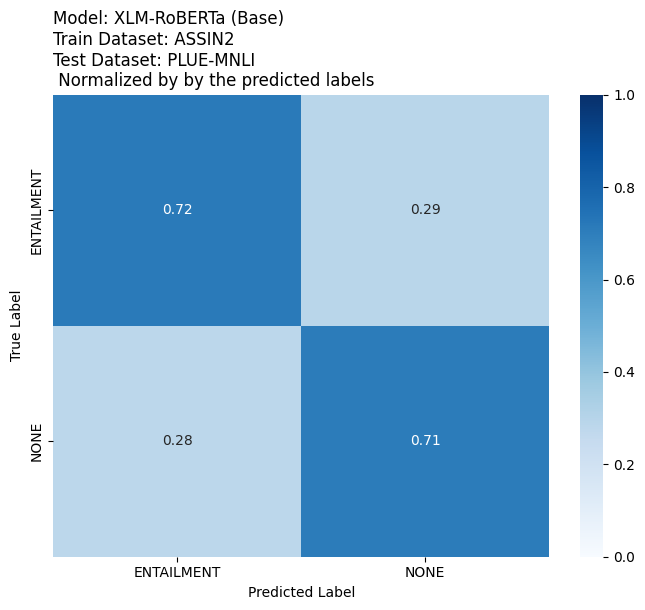

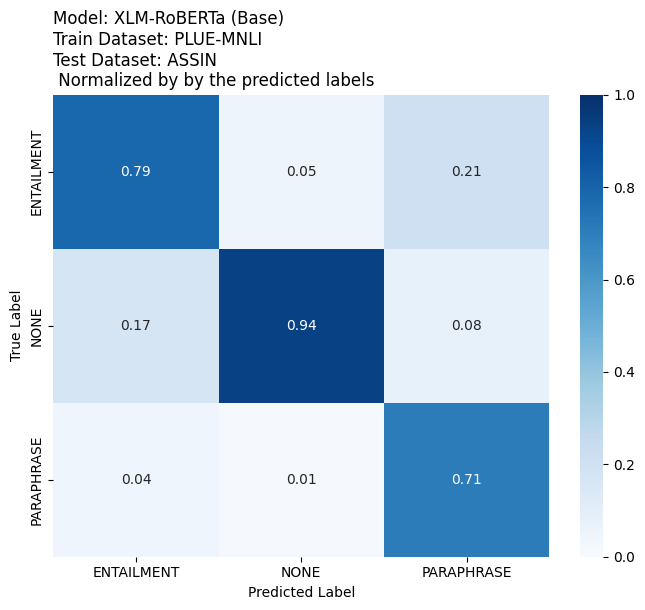

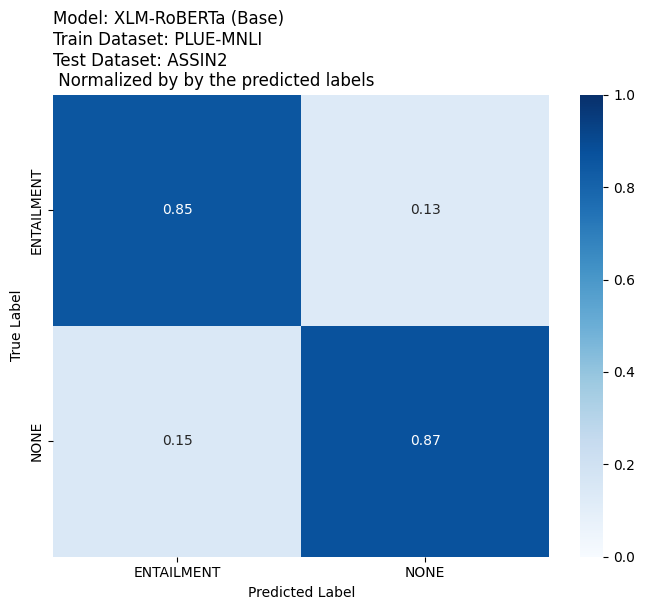

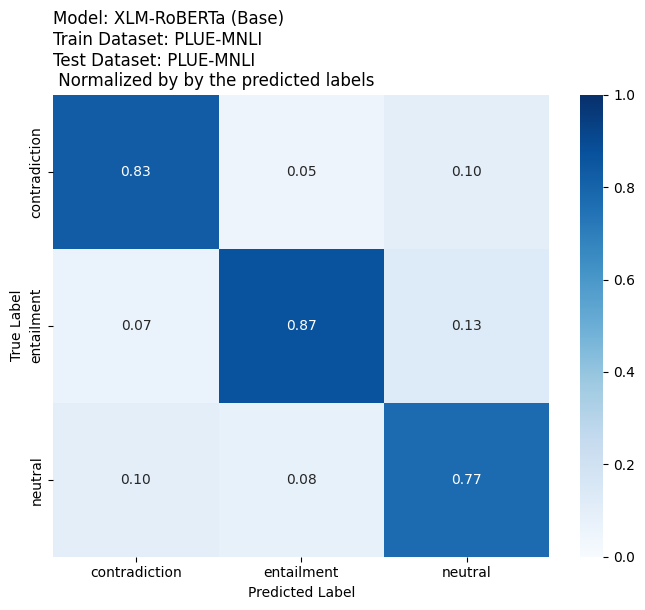

In [6]:
plot_consufion_matrices(grouped, normalize='pred')

In [7]:
def mount_metrics_dataframe(groups: list, df: pd.DataFrame) -> pd.DataFrame:
    grouped = df.groupby(groups)
    rows = []
    for (model_name, train_dataset, test_dataset), group in grouped:
        labels = group['label'].unique()
        metrics = {
            'model_name': model_name,
            'test_dataset': test_dataset,
            'train_dataset': train_dataset,
            'accuracy': accuracy_score(group['label'], group['prediction']),
            'f1': f1_score(group['label'], group['prediction'], average='macro'),
            'precision': precision_score(group['label'], group['prediction'], average='macro'),
            'recall': recall_score(group['label'], group['prediction'], average='macro')
        }

        for label in labels:
            binarized_true = (group['label'] == label).astype(int)
            binarized_pred = (group['prediction'] == label).astype(int)
            
            metrics[f'{label}_accuracy'] = accuracy_score(binarized_true, binarized_pred)
            metrics[f'{label}_f1'] = f1_score(binarized_true, binarized_pred)
            metrics[f'{label}_precision'] = precision_score(binarized_true, binarized_pred)
            metrics[f'{label}_recall'] = recall_score(binarized_true, binarized_pred)
        
        rows.append(metrics)

    return pd.DataFrame(rows)

In [8]:
groups =  ['model_name', 'train_dataset', 'test_dataset']
metrics_to_see = ['accuracy', 'f1', 'recall', 'precision']
metrics_df = mount_metrics_dataframe(groups, df)
metrics_df.to_csv('results.csv', index=False)

/home/giogvn/Natural-Portuguese-Language-Inference/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/giogvn/Natural-Portuguese-Language-Inference/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/giogvn/Natural-Portuguese-Language-Inference/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

In [9]:
precision = ".2f"
def plot_metrics_results(metrics_df: pd.DataFrame, model_name: str, metric: str):
    plot = metrics_df[metrics_df['model_name'] == model_name].pivot(index = "train_dataset",
                                                                    columns = "test_dataset",
                                                                    values = metric)
    plt.figure(figsize=(8,6))
    sns.heatmap(plot, annot=True, cmap = 'Blues',fmt=precision, vmin=0.5, vmax=1)
    plt.title(f"{metric[0].upper() + metric[1:]} for {model_name}")
    plt.show()

In [10]:
def plot_models_benchmark_results(metrics_df: pd.DataFrame, metric: str):
    plot = metrics_df.pivot(index = "test_dataset",columns = "model",values = metric)
    plt.figure(figsize=(8,6))
    sns.heatmap(plot, annot=True, cmap = 'Blues',fmt=precision, vmin=0.5, vmax=1)
    plt.title(f"Models' {metric} comparison")
    plt.xticks(rotation=90)
    plt.show()

['ASSIN' 'ASSIN2' 'PLUE-MNLI']


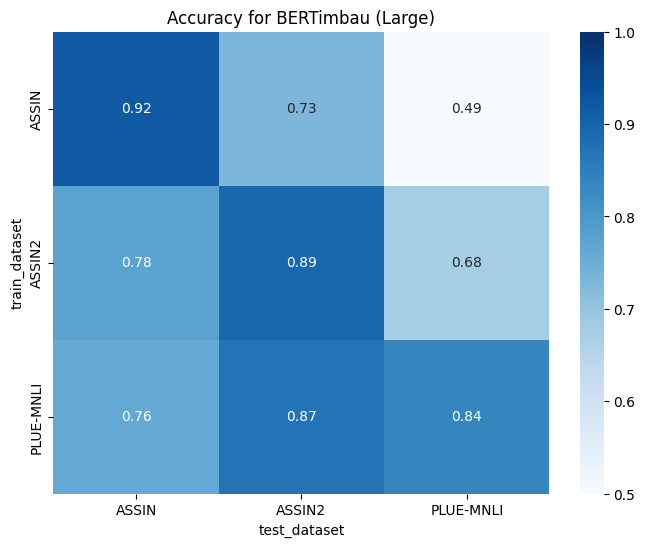

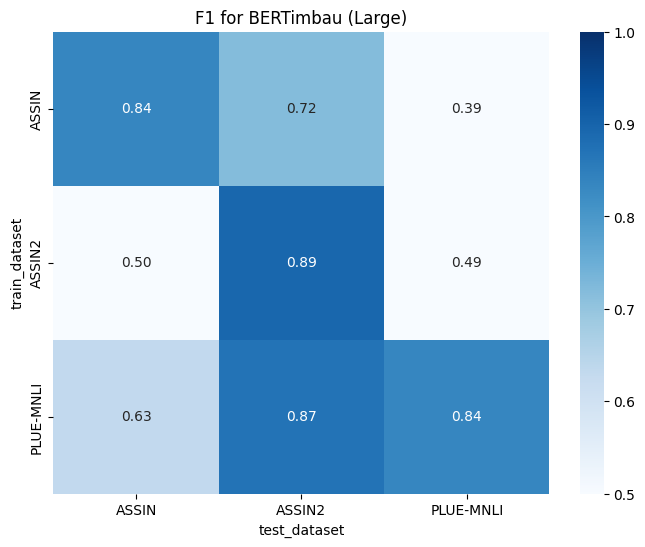

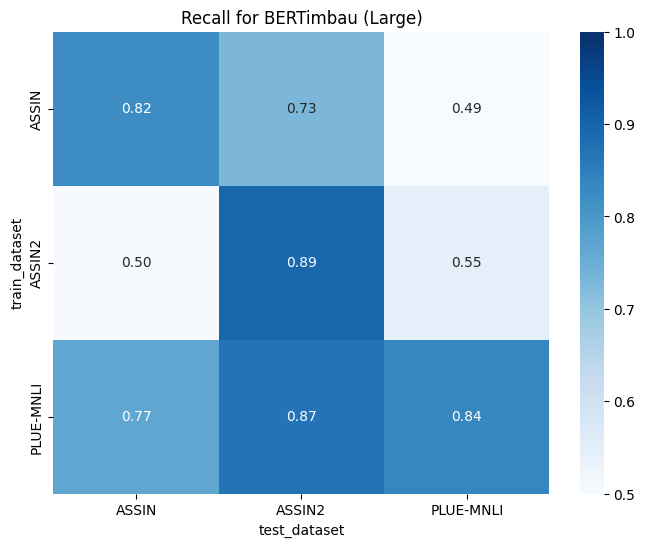

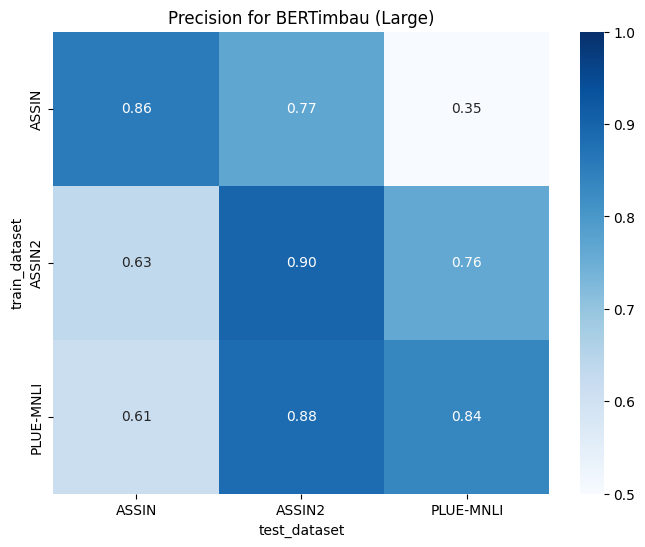

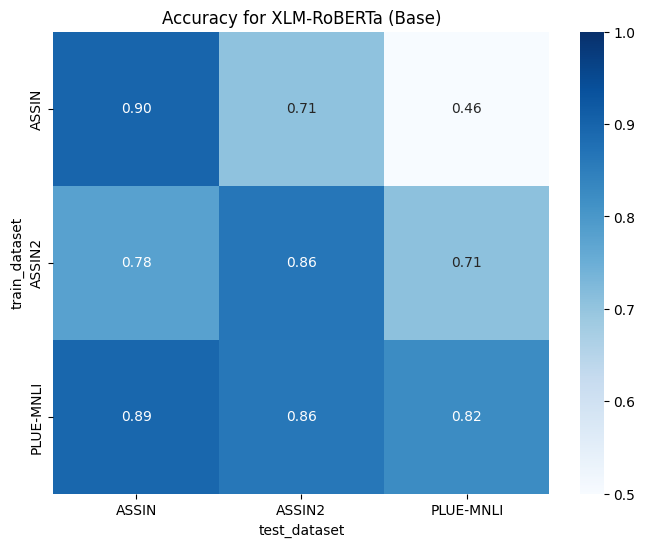

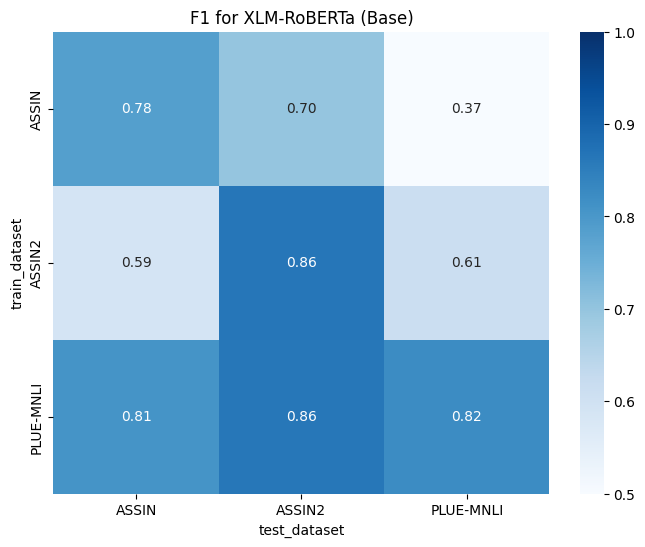

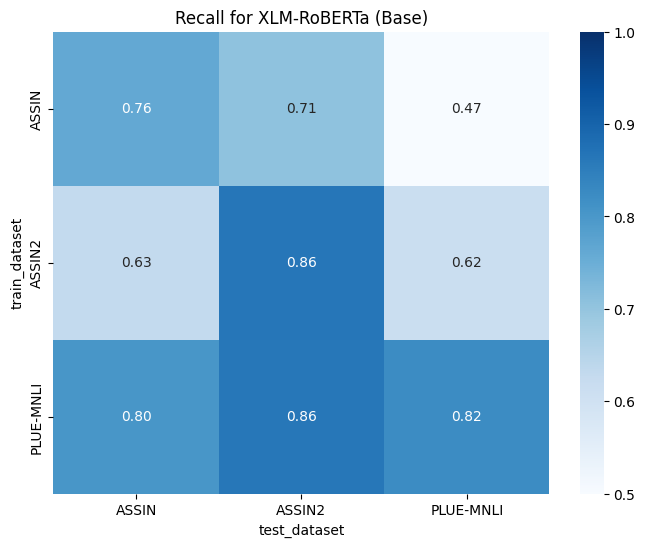

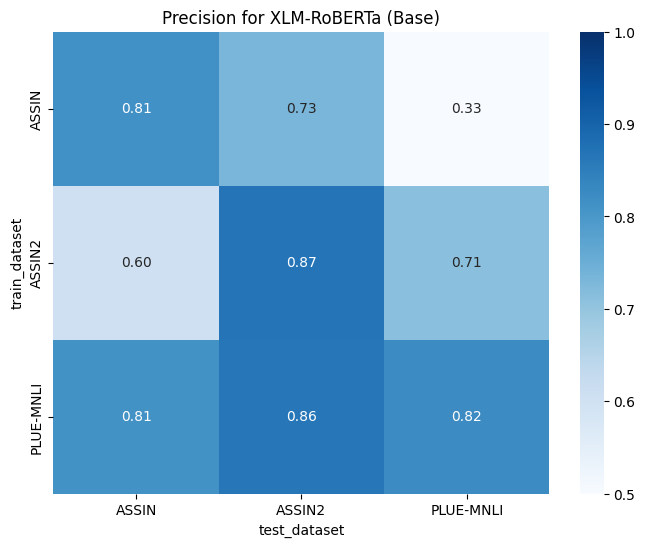

In [11]:
model_names = metrics_df['model_name'].unique()
print(metrics_df['test_dataset'].unique())
for model_name in model_names:
    for metric in ['accuracy', 'f1', 'recall', 'precision']:
        plot_metrics_results(metrics_df, model_name, metric)

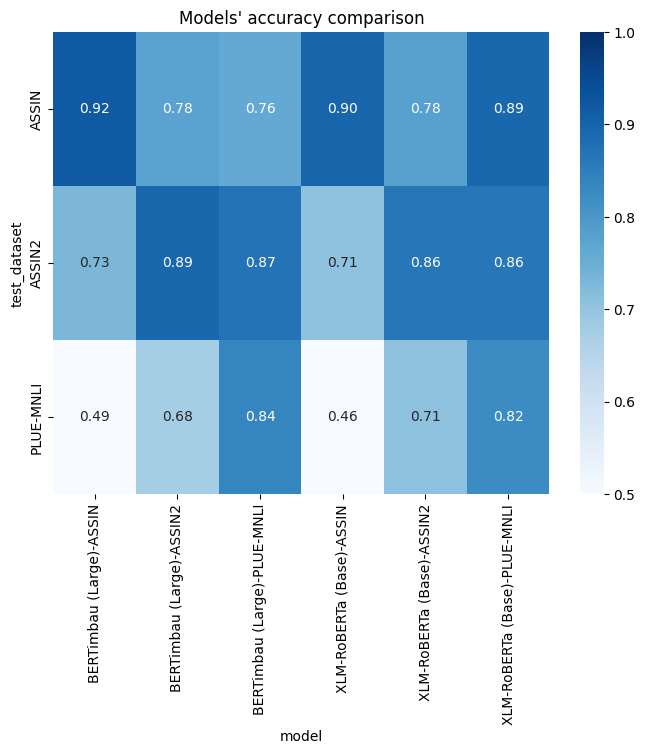

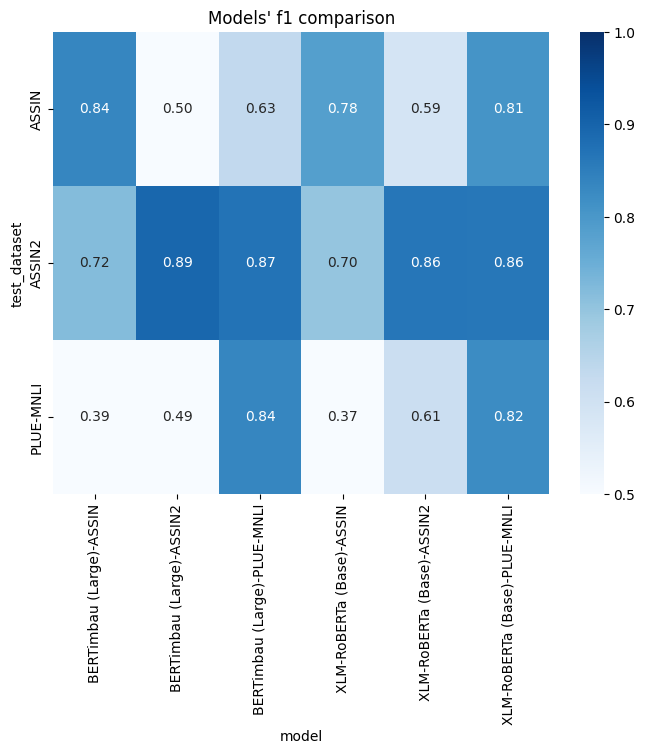

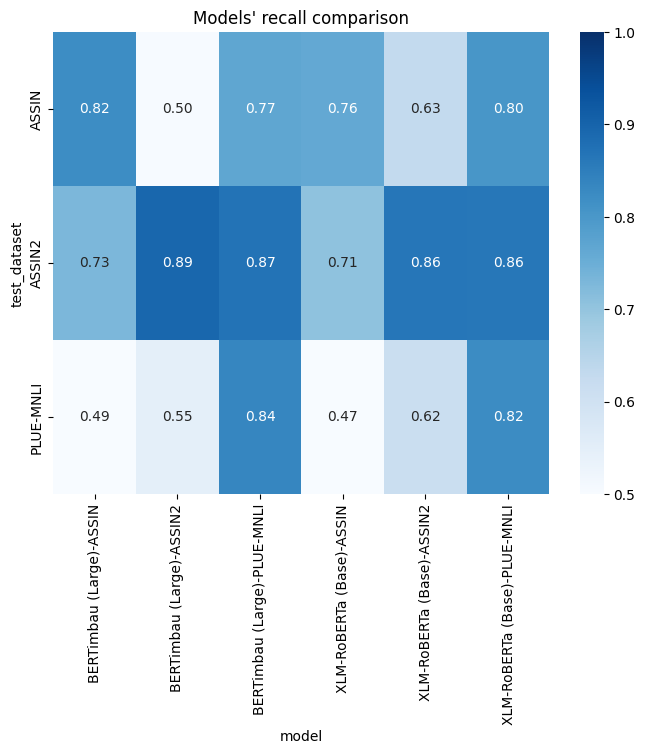

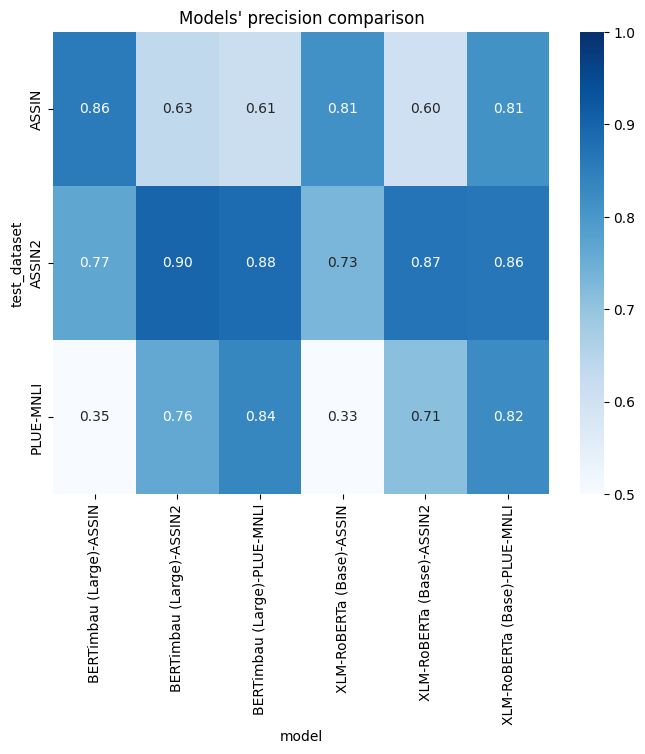

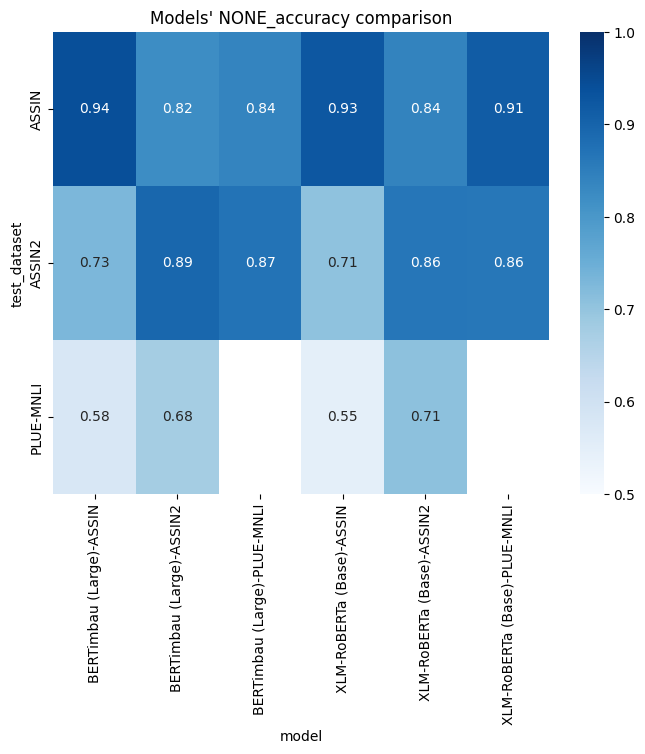

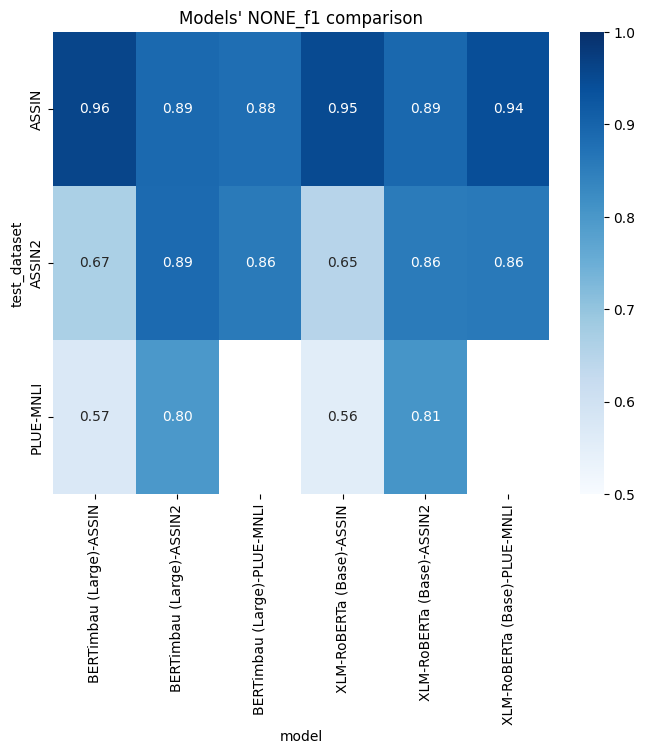

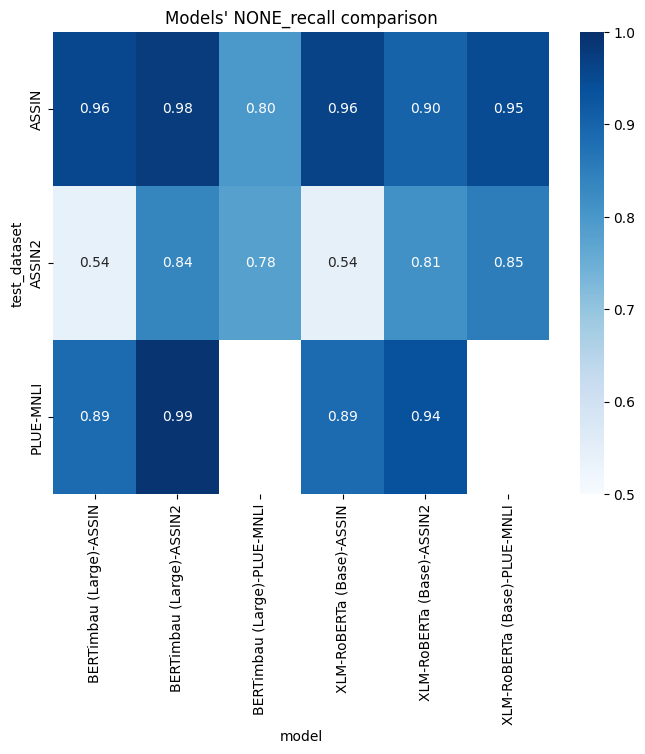

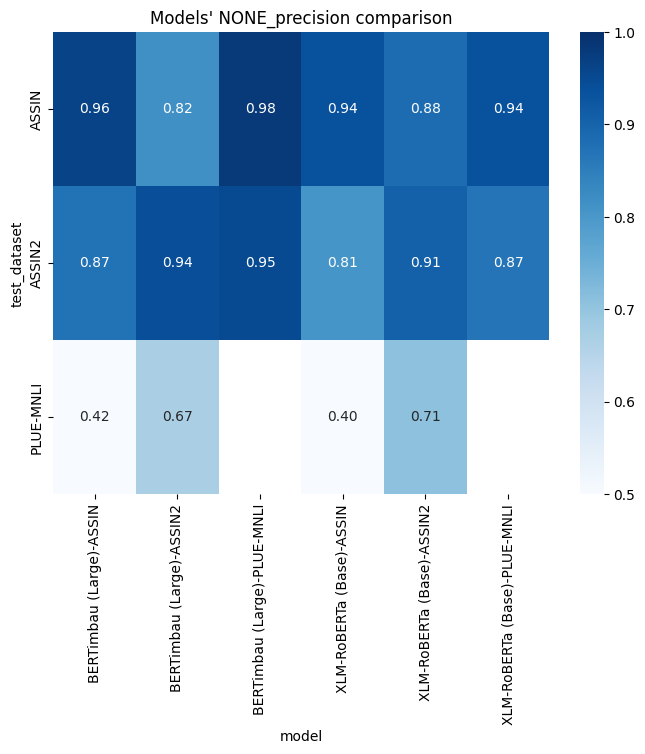

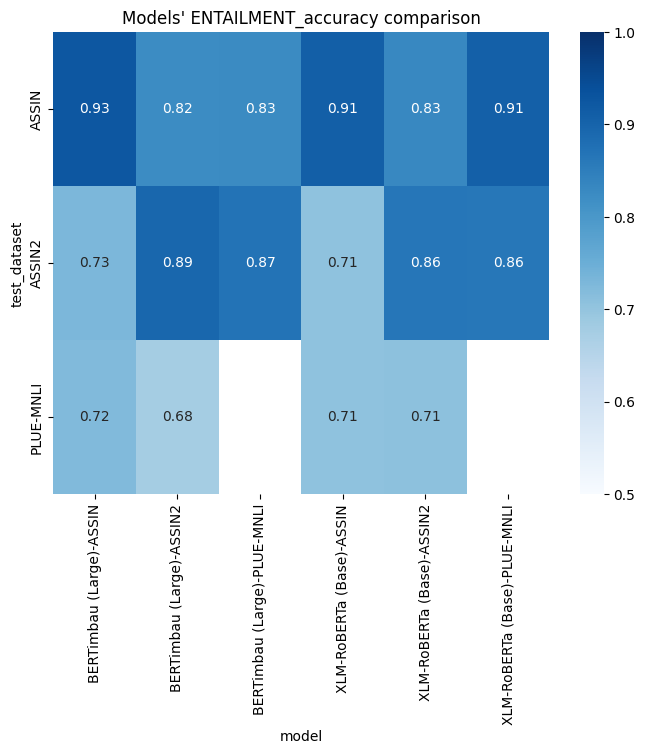

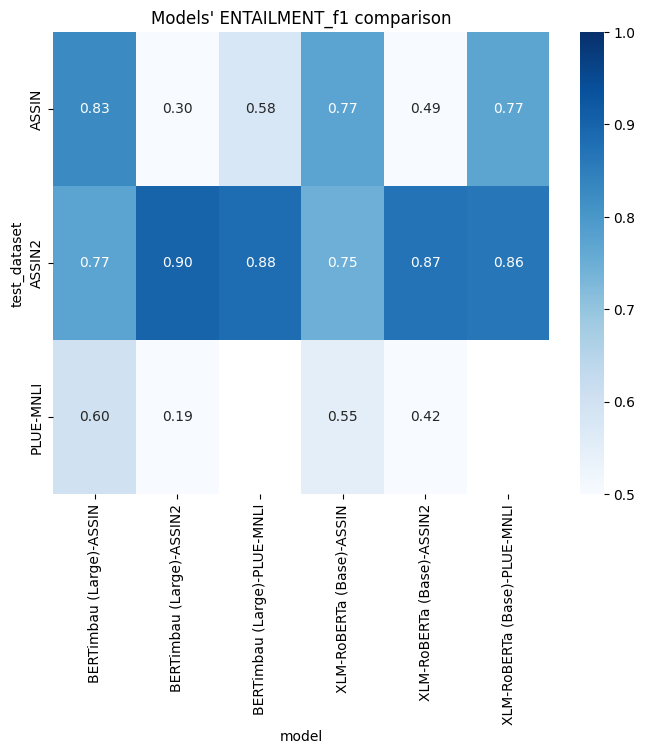

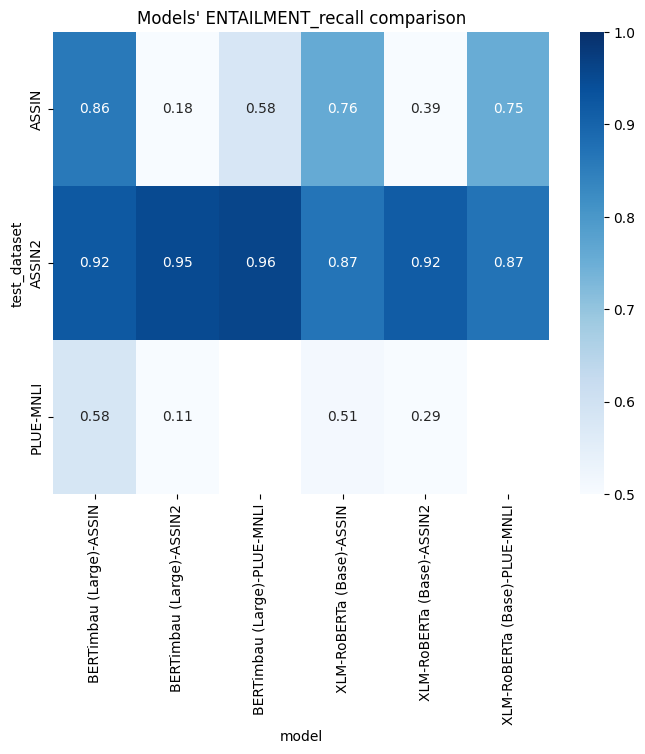

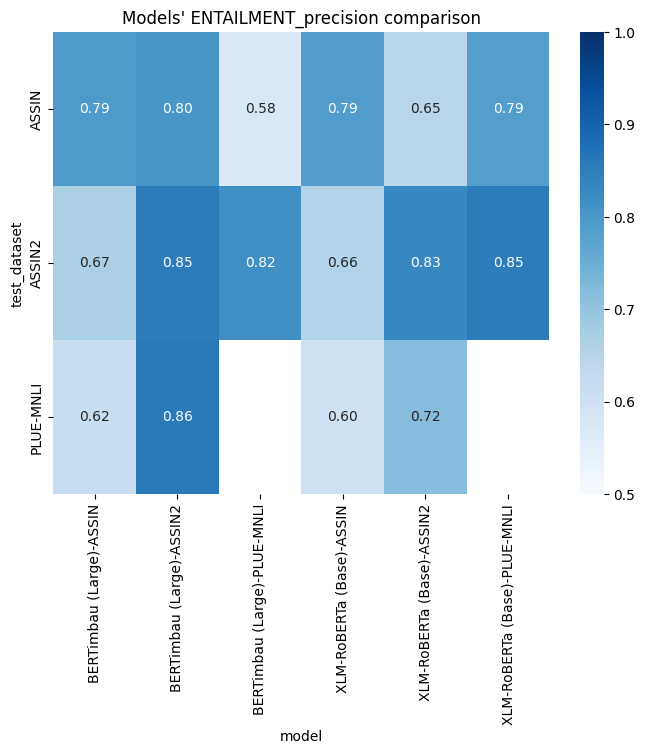

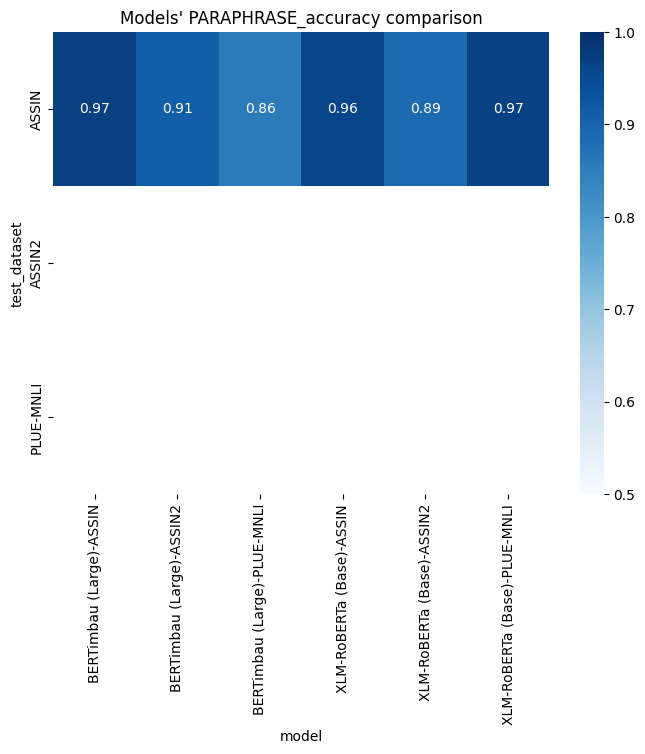

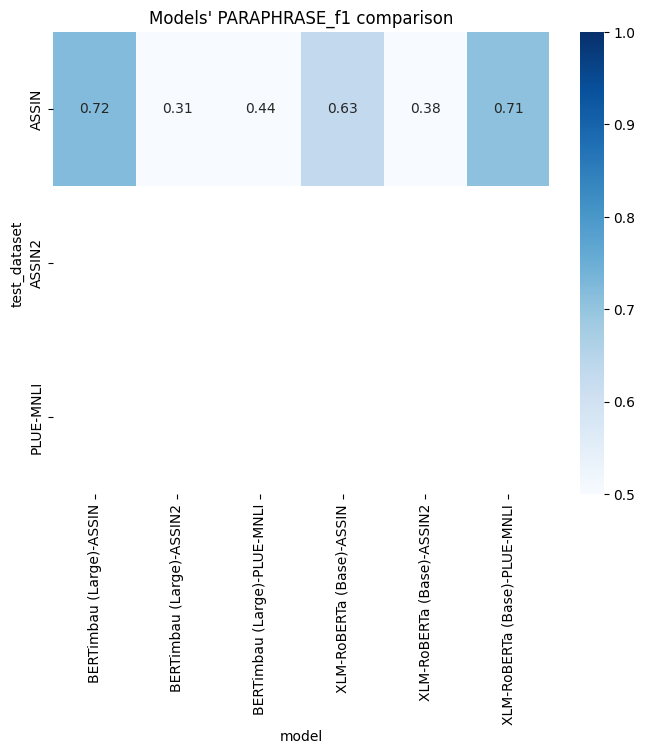

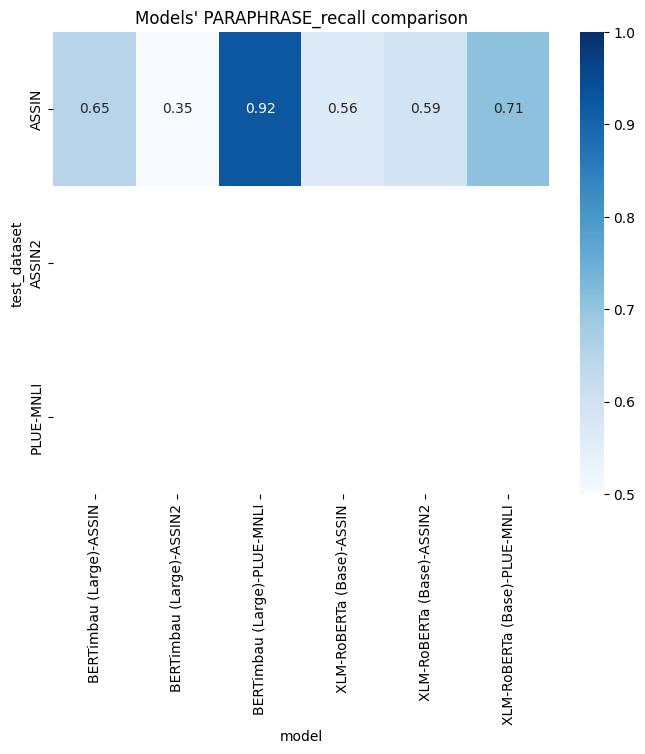

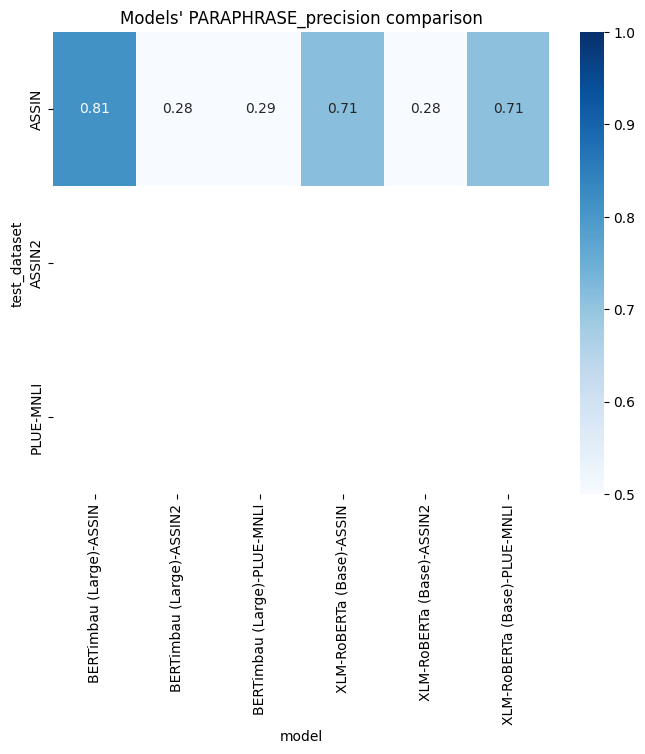

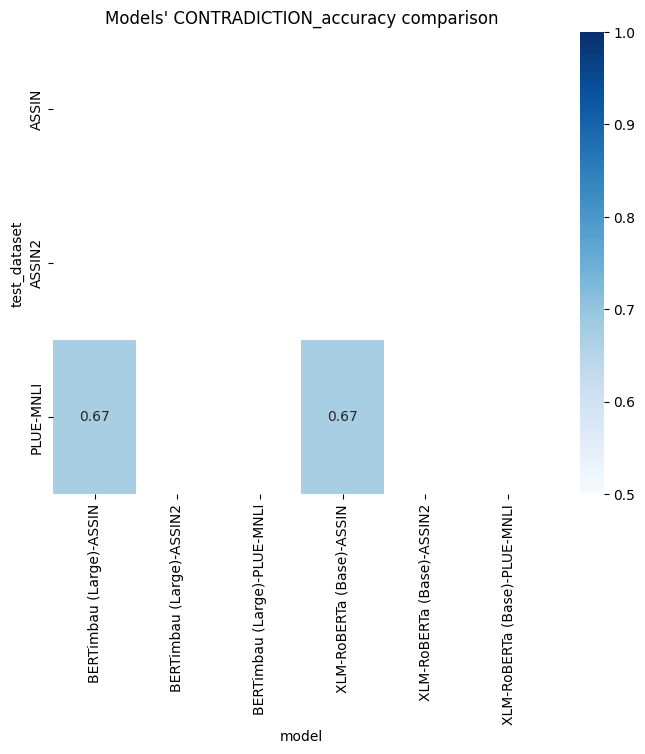

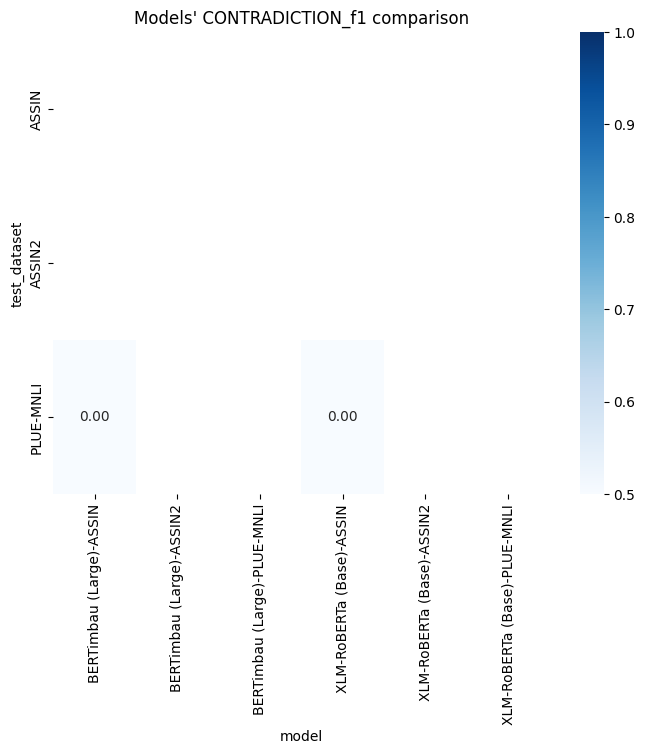

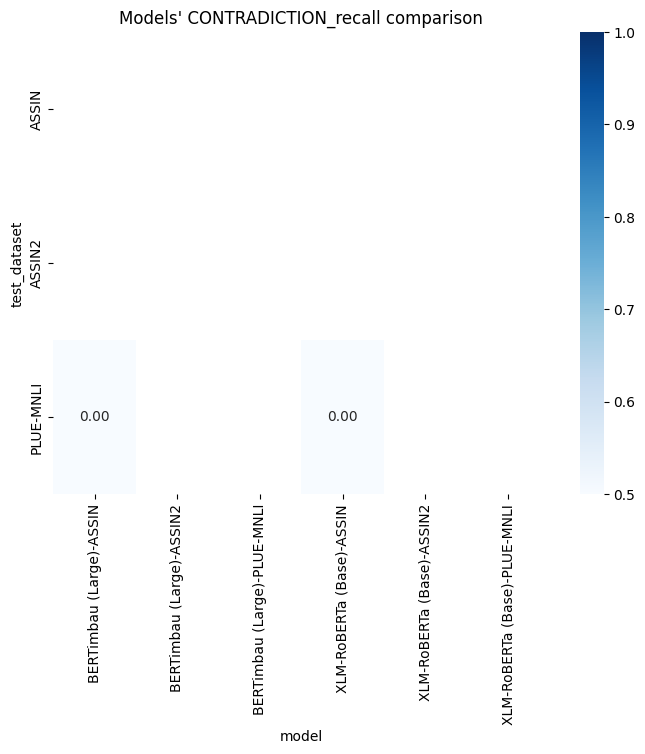

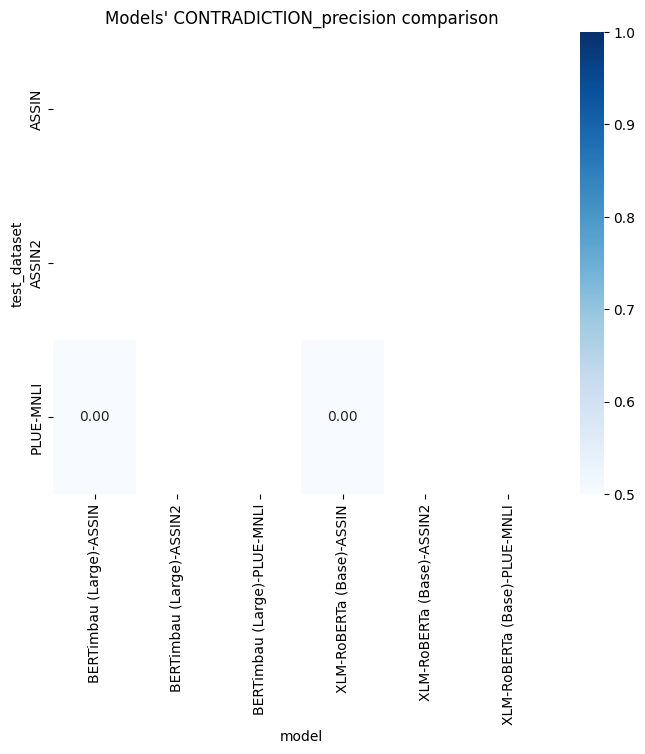

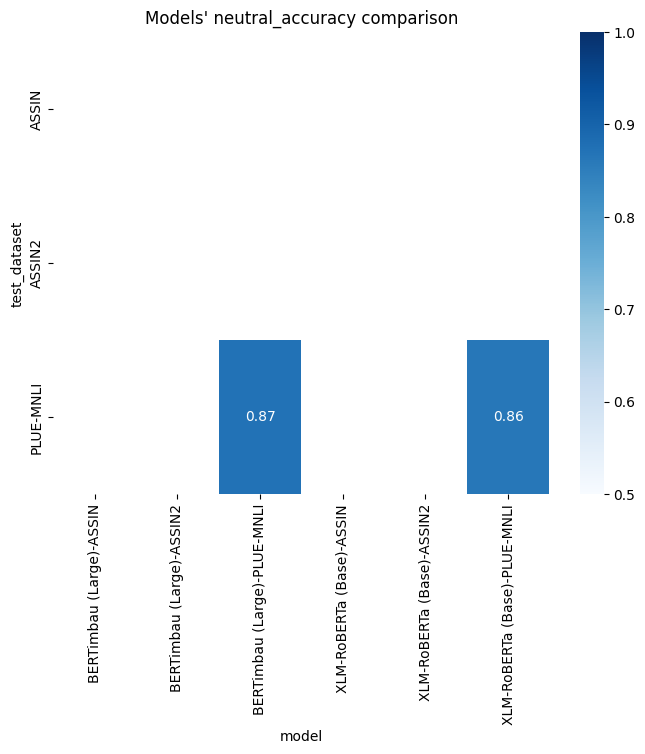

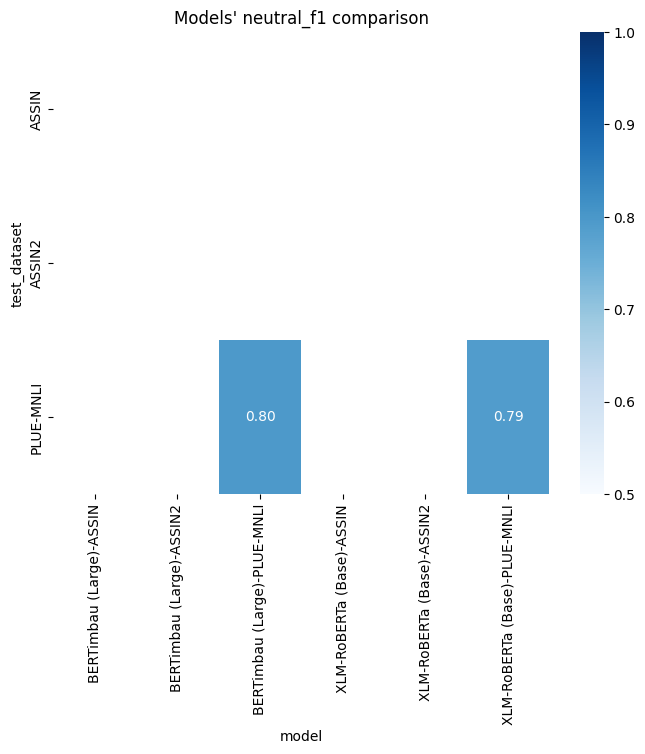

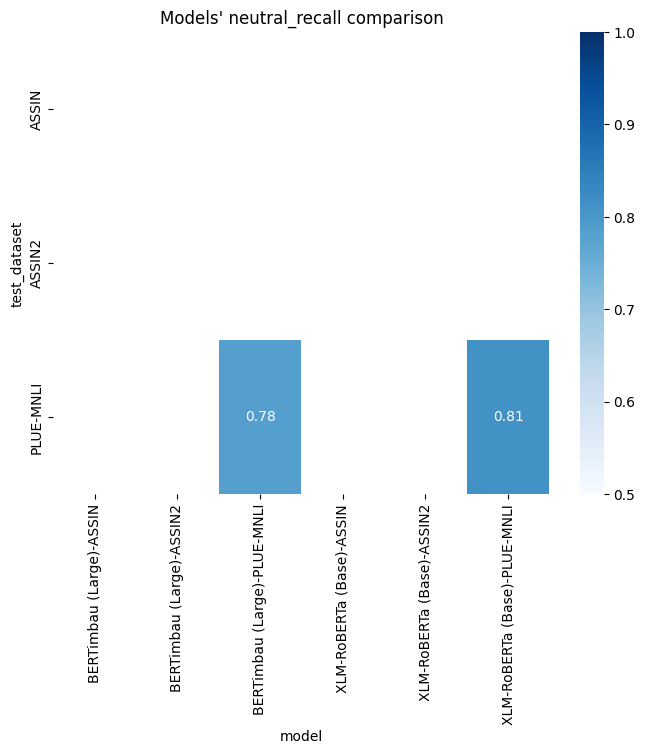

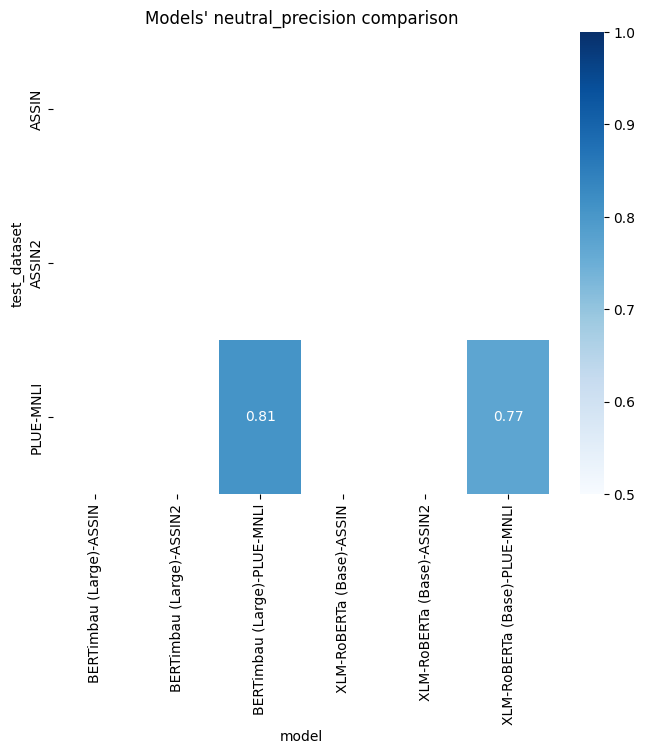

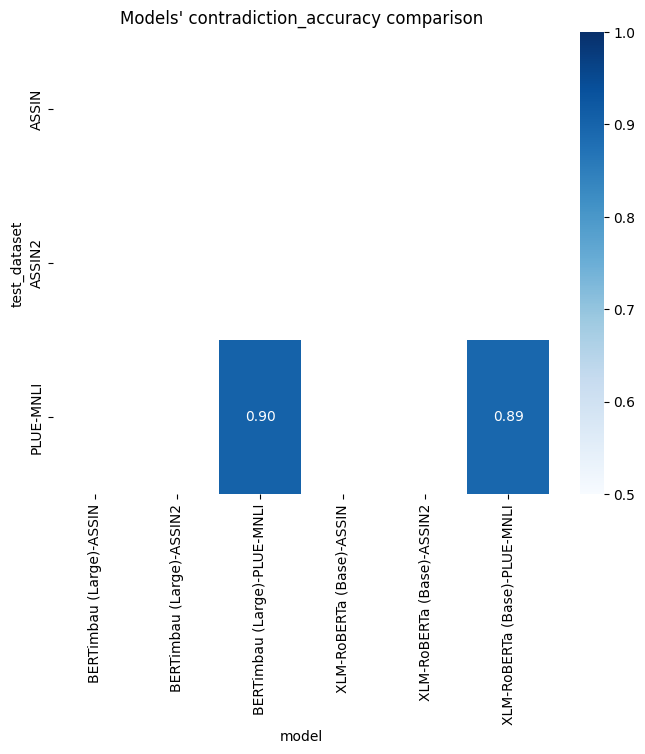

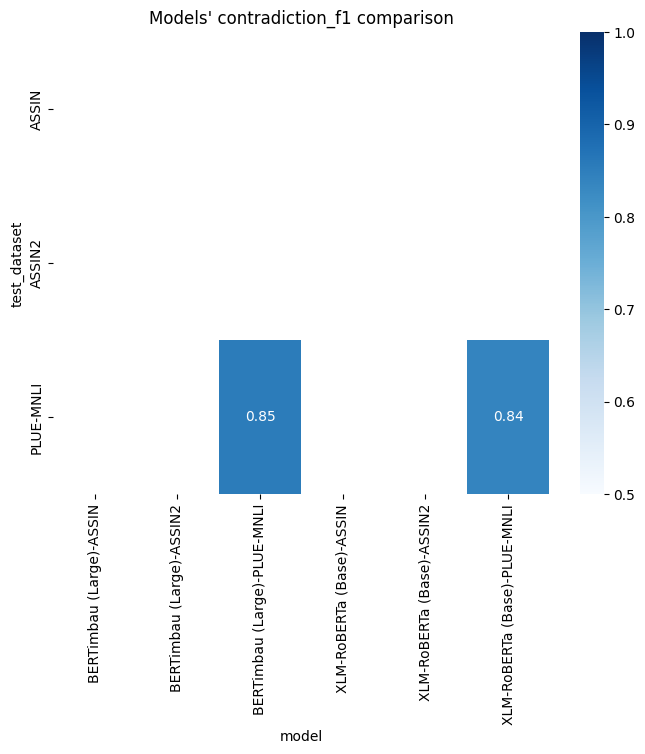

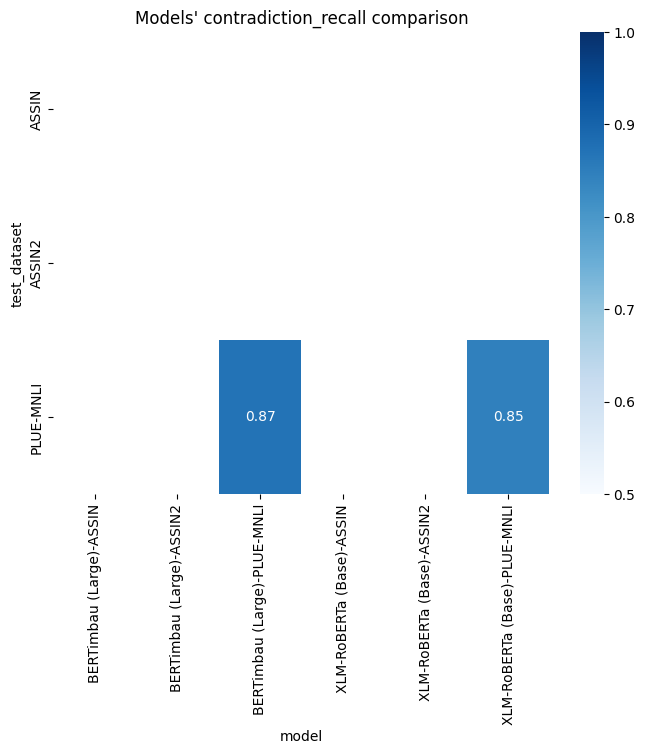

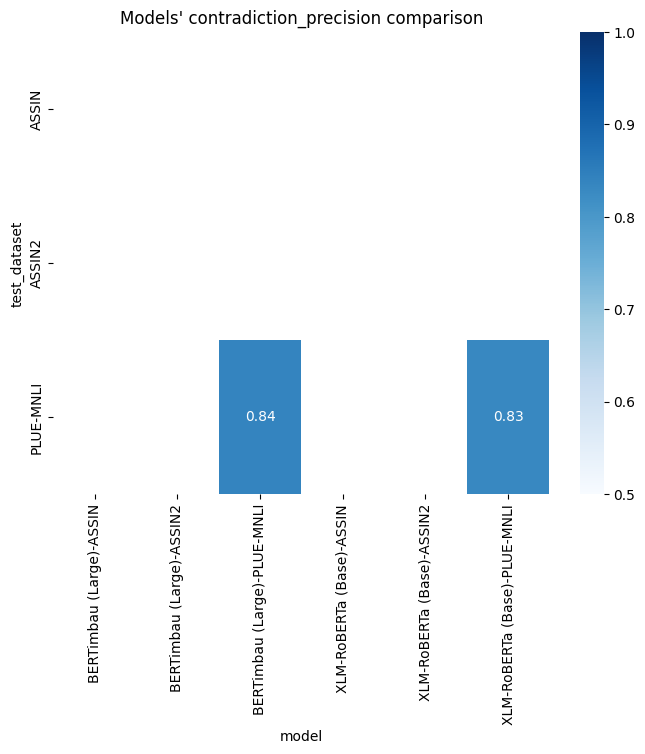

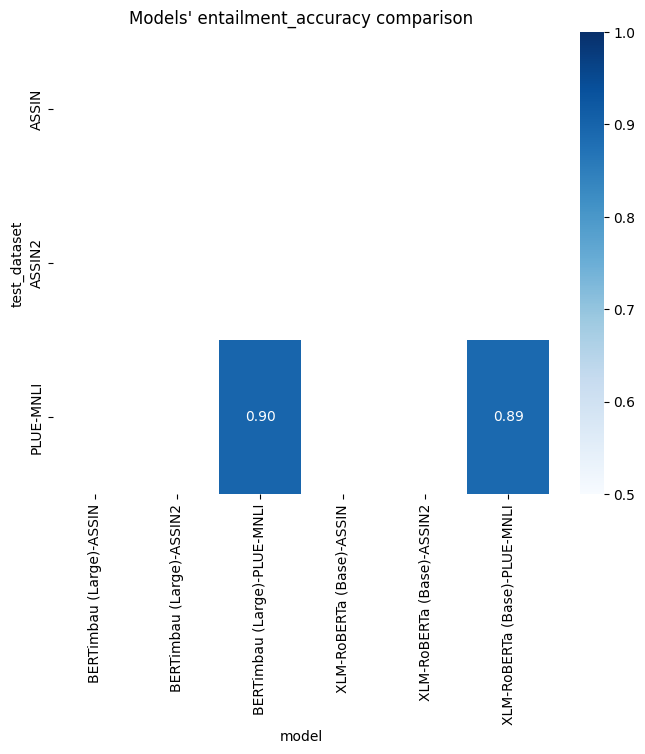

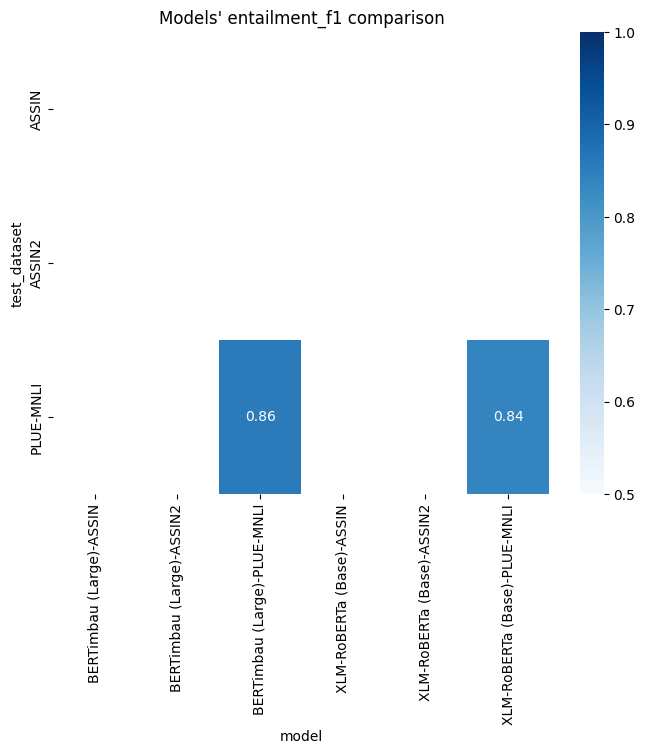

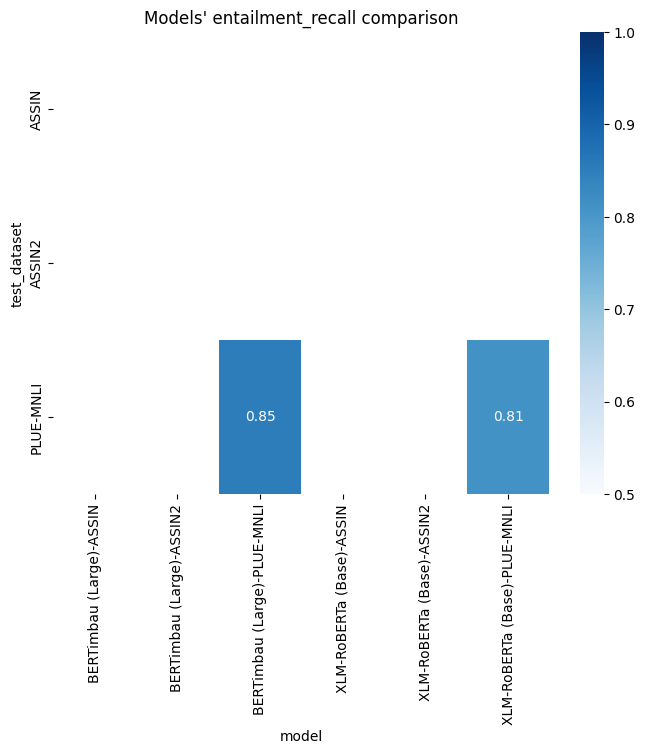

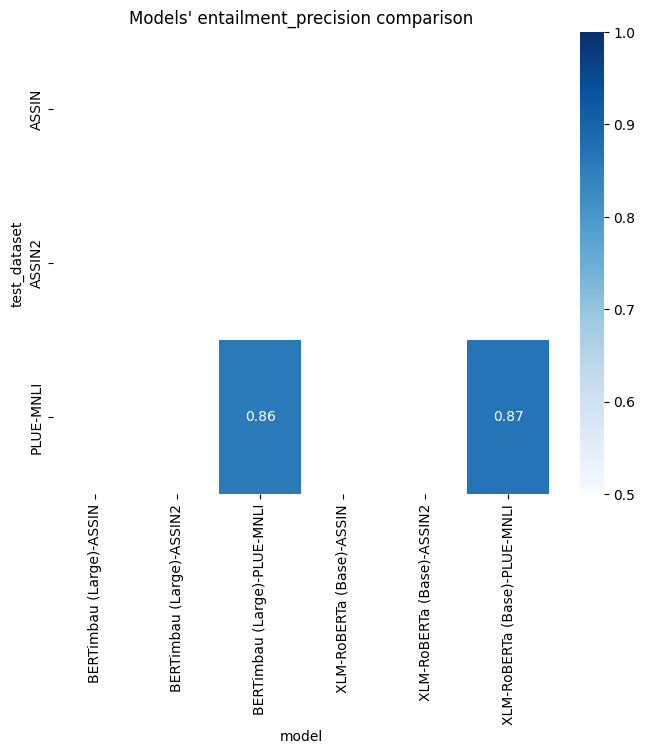

In [12]:
metrics_df["model"] = metrics_df["model_name"] + '-' + metrics_df["train_dataset"]
labels = df['label'].unique()
metrics_to_see.extend([label + '_' + metric for label in labels for metric in metrics_to_see])

for metric in metrics_to_see:
    plot_models_benchmark_results(metrics_df, metric)
